In [42]:
import numpy as np
from scipy import ndimage, fft, stats
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import timeit

In [43]:
PLOT_RESULTS = True
RADIUS = 30
STD = 5
DPI=120

## 1.1 Fourier transformation

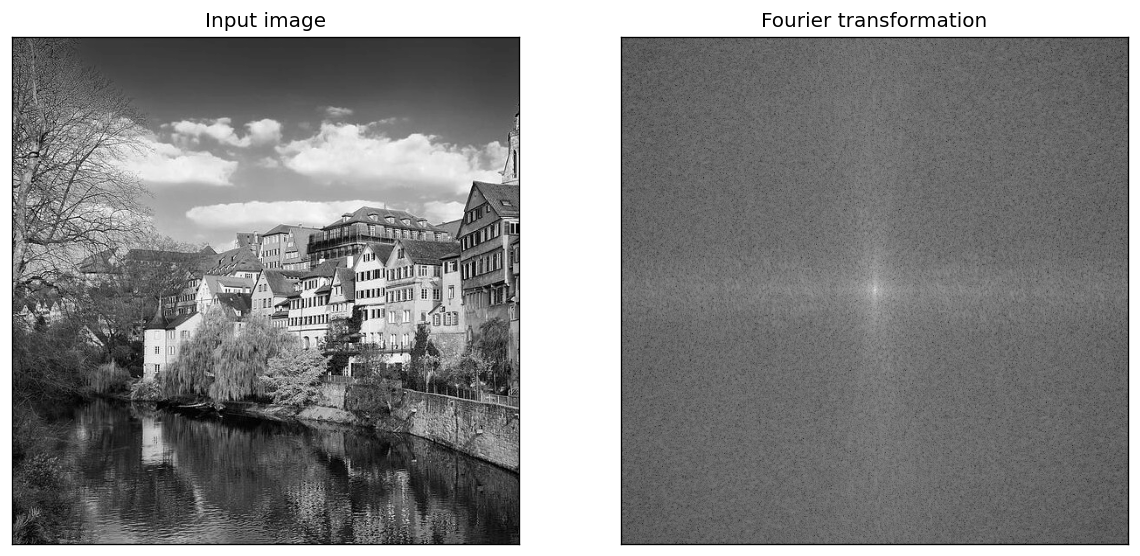

In [44]:
# ----- load the input image
img = imread('inputs/tuebingen.jpg')[:, :, 1] / 255.  
img_size = img.shape[0]


# TODO
FT_img_log = np.log(np.abs(fft.fftshift(fft.fft2(img))))


# ----- plot input image together with fourier transformation
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, cmap = 'gray')
    plt.title('Input image')

    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(FT_img_log, cmap='gray')
    plt.title('Fourier transformation')
    plt.show()

## 1.2 High-pass filter in spectral space

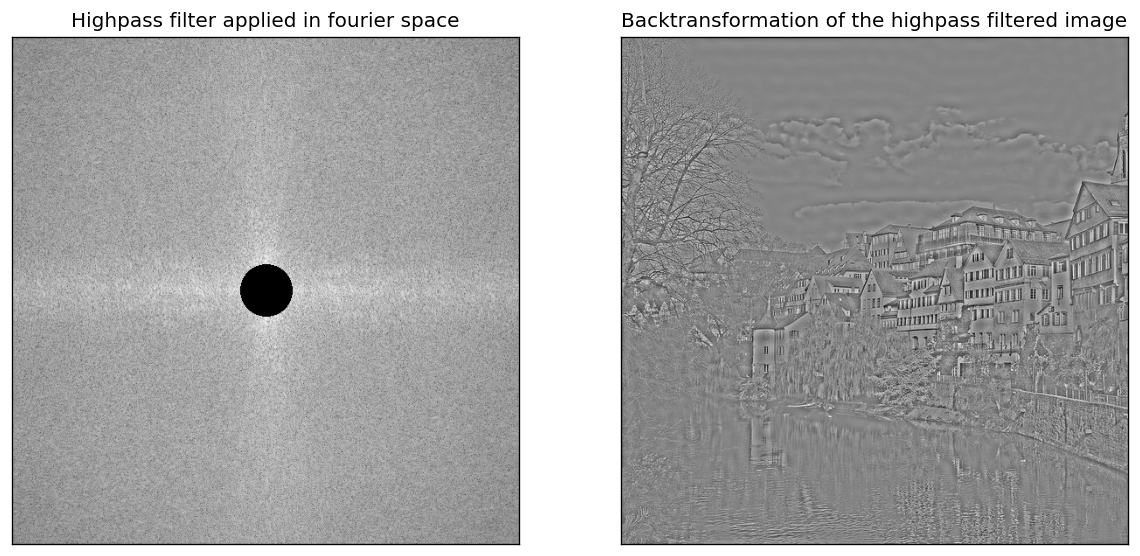

In [45]:
# TODO
def highpass_filter(img_size, radius):
    ''' Returns a highpass filter.
    input:
        img_size: length of the filter
        redius: radius of the circular aperture
    output:
        highpass: a filter of size(img_size, img_size) with values zero and one
    '''
    
    # Use an ogrid to create indices in regard to the center of the image
    y,x = np.ogrid[-img_size/2:img_size/2, -img_size/2:img_size/2]

    # calculate the distance for each pixel from the center
    dist_from_center = np.sqrt(x**2 + y**2)

    # Create a circular mask based on radius
    mask = dist_from_center > radius # high frequencies at outside edge are kept
    return mask

# Apply the highpass filter to the image in frequency domain
## Get mask to apply to frequency domain
highpass = highpass_filter(img_size, radius=RADIUS)

## Get image in frequency domain
img_freq = fft.fftshift(fft.fft2(img))
img_highpass =  img_freq * highpass


# Transform the spectrum back to image space                     
img_filtered = np.real(fft.ifft2(fft.ifftshift(img_highpass)))

if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(img_highpass)**0.15, cmap = 'gray')   # Potenz dient der Kontrastanpassung
    plt.title('Highpass filter applied in fourier space')

    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_filtered), cmap=plt.cm.gray)
    plt.title('Backtransformation of the highpass filtered image')
    plt.show()

## 1.3 Gaussian filter

### 1.3.1 Construct a Gaussian filter

In [46]:
def g_kern(kernlen=5, std=1):
    ''' Returns a 2D Gaussian kernel with standard devitation sig
    input:
        kernlen: length of the filter
        std: standard deviation of the gaussian in pixels
    output:
        g_kern_2d: a gaussian kernel of size (kernlen, kernlen) with sum 1
    '''
    # If kernlen is even, increment it by 1 to make it odd
    if kernlen % 2 == 0:
        kernlen += 1
    
    # Create a 1D Gaussian kernel centered at 0
    g_kern_1d = stats.norm.pdf(np.linspace(-(kernlen-1)/2.,
                                            (kernlen-1)/2., kernlen), 
                                            scale=std)

    # Make it 2D by outer product
    g_kern_2d = np.outer(g_kern_1d, g_kern_1d)
    
    return g_kern_2d

def g_kern_cut(img_size, std, kernlen):
    """ 
    Cuts out a window from the input Gaussian kernel. Not really necessary for
    our small std, but maybe for larger kernels? 
    
    !No, it doesn't matter, since linspace generates n=kernlen equally spaced 
    !numbers from the intervall. So the y-values from pdf are the same for the same 
    !x-values, no matter the size of the kernel. This func is not needed in our case.
    Inputs:
        kernel: 2D numpy array representing the Gaussian kernel
        std: Standard deviation of the Gaussian kernel
        factor: Factor of standard deviation to define the window size
    Output:
        windowed_kernel: Kernel window cut from the original kernel
    """
    # Create a 2D Gaussian kernel
    kernel = g_kern(img_size, std)

    # Determine window size, ensuring it's an odd number
    window_size = int(kernlen * std)
    if window_size % 2 == 0:
        window_size += 1  # make it odd
    #print(window_size)

    # Calculate the start and end indices to slice the kernel
    kernlen = kernel.shape[0]  # assuming the kernel is square
    start = (kernlen - window_size) // 2
    end = start + window_size

    # Cut out the smaller window from the kernel
    windowed_kernel = kernel[start:end, start:end]

    return windowed_kernel

### 1.3.2 Apply Gaussian filter in image space

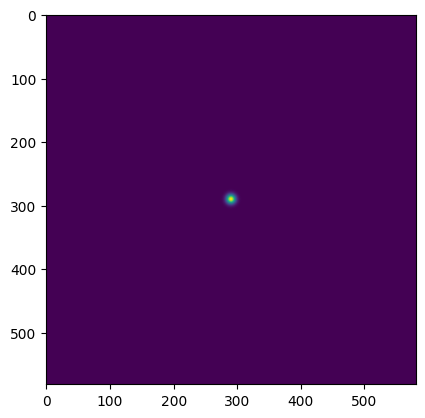

In [47]:
std = 5
gaussfilter_img = g_kern(img_size, std=std)

plt.imshow(gaussfilter_img)
def apply_convolution_2d(img, kernel):
    img_conv = ndimage.convolve(img, kernel)
    return img_conv
conv_kernel = g_kern(6 * std, std=std)
img_conv = apply_convolution_2d(img, conv_kernel)

### 1.3.3 Transform the Gaussian filter to fourier space

In [48]:
#   step 3: transform the gaussian kernel to fourier space
gaussfilter_f = fft.fft2(gaussfilter_img)
gaussfilter_f_shift = fft.fftshift(gaussfilter_f)

### 1.3.4 Apply this filter in fourier space

In [49]:
def apply_gauss_via_fourier(img, gaussfilter_img):
    gaussfilter_f = fft.fft2(gaussfilter_img)
    gaussfilter_f_shift = fft.fftshift(gaussfilter_f)

    img_freq = fft.fftshift(fft.fft2(img))
    img_gauss_f = img_freq * np.abs(gaussfilter_f_shift)
    img_gauss_f = np.real(fft.ifft2(fft.ifftshift(img_gauss_f)))
    return img_gauss_f

img_gauss_f = apply_gauss_via_fourier(img, gaussfilter_img)

### 1.3.5. Visuallise and compare two filtering methods

difference: 0.0035450227743409547


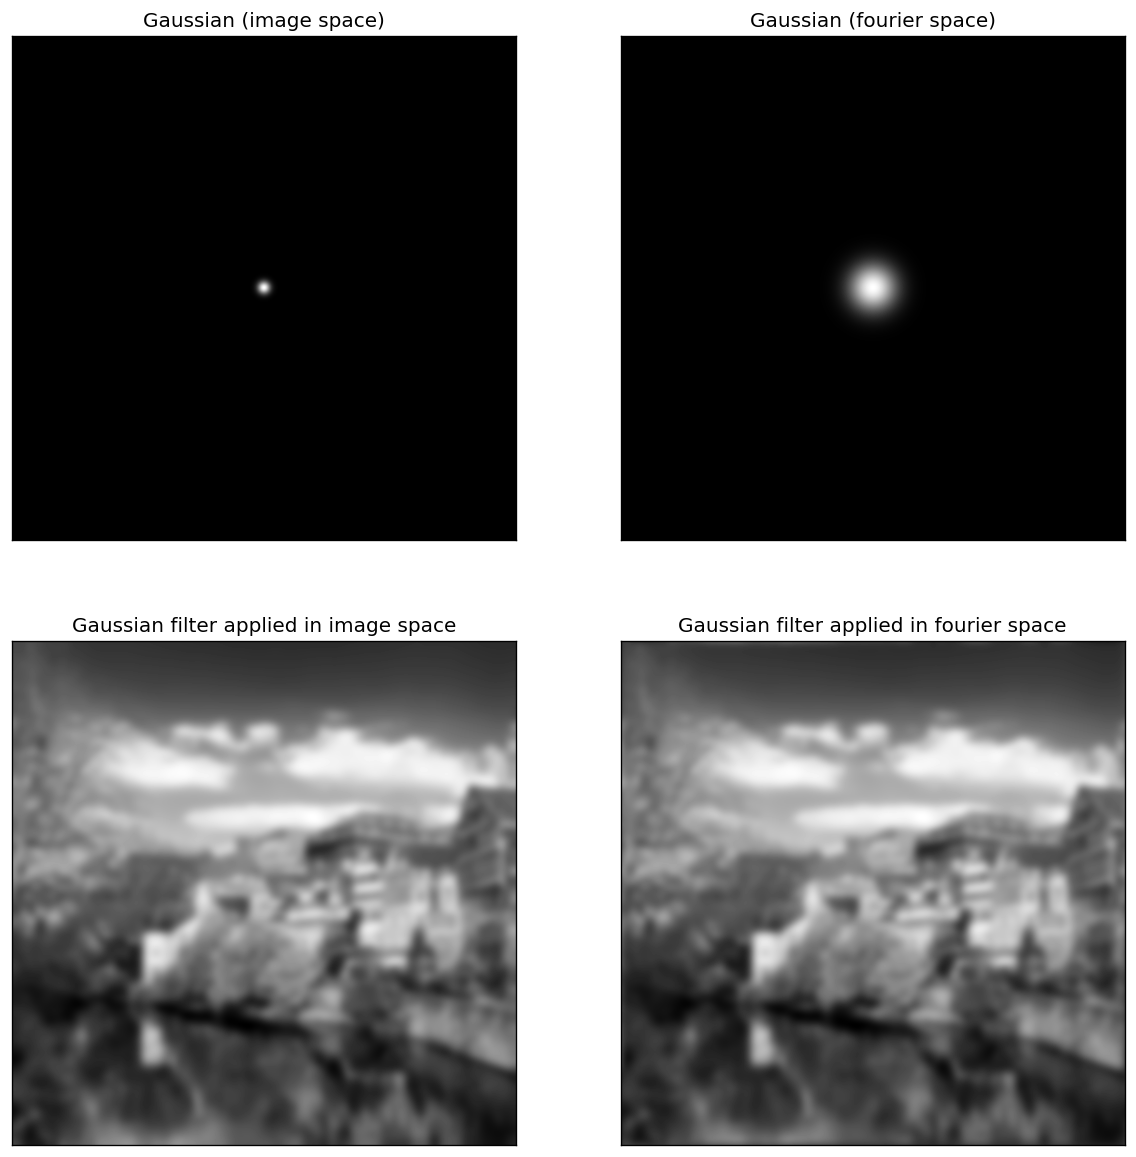

In [50]:
#   step 5: compare the results
difference = np.mean(np.abs(img_gauss_f - img_conv))       
print('difference: ' + str(difference))

if PLOT_RESULTS:
    # compare the two images
    plt.figure(figsize=(12, 12),dpi=DPI)

    plt.subplot(221)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((gaussfilter_img), cmap=plt.cm.gray)
    plt.title('Gaussian (image space)')

    plt.subplot(222)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(gaussfilter_f_shift), cmap=plt.cm.gray)
    plt.title('Gaussian (fourier space)')

    plt.subplot(223)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      # img_conv
    plt.title('Gaussian filter applied in image space')

    plt.subplot(224)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_gauss_f), cmap=plt.cm.gray)
    plt.title('Gaussian filter applied in fourier space')

    plt.show()

### 1.3.6 Splitted convolutional filter

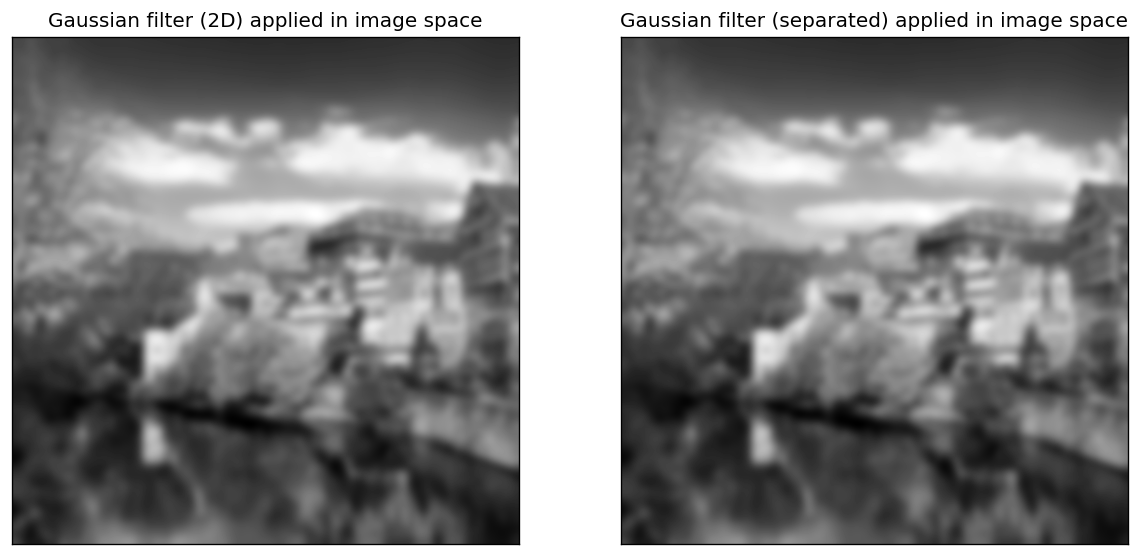

In [51]:
# TODO
def g_kern1d(kernlen=5, std=1):
    '''
    Returns a 1D Gaussian kernel with standard devitation sig 
    input:
        kernlen: length of the filter std: standard deviation of the gaussian in  pixels 
    output: 
        g_kern_1d: a gaussian kernel of size (kernlen, 1)
    '''
    # If kernlen is even, increment it by 1 to make it odd
    if kernlen % 2 == 0:
        kernlen += 1

    g_kern_1d = stats.norm.pdf(np.linspace(-(kernlen-1)/2.,
                                            (kernlen-1)/2., kernlen), 
                                            scale=std) 
    return g_kern_1d

def apply_convolution_yx(img, kernel_1d):
    img_y = ndimage.convolve1d(img, kernel_1d, axis=0) # y-axis
    img_yx = ndimage.convolve1d(img_y, kernel_1d, axis=1) # x-axis
    return img_yx

gaussfilter_img_1D = g_kern1d(30, std=std)
img_conv_sep_final = apply_convolution_yx(img, gaussfilter_img_1D)


# ----- plot results
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      
    plt.title('Gaussian filter (2D) applied in image space')
    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img_conv_sep_final, cmap='gray')
    plt.title('Gaussian filter (separated) applied in image space')
    plt.show()

### Differences in time and image domain of the implementations

In [58]:
# assuming above code was executed
from tabulate import tabulate

# function to measure execution time
def measure_time(func, repeat=1):
    times = timeit.repeat(func, repeat=repeat, number=1)
    return np.mean(times)

# function to apply and measure each function
def apply_and_measure(function, img, filter):
    def func_to_measure():
        return function(img, filter)

    time = measure_time(func_to_measure)
    result = func_to_measure()

    return result, time

# function to calculate difference
def calculate_difference(img1, img2):
    diff = np.abs(img1 - img2)
    return np.mean(diff)

# apply and measure time for each function
result_conv_2d, time_conv_2d = apply_and_measure(apply_convolution_2d, img, conv_kernel)
result_conv_yx, time_conv_yx = apply_and_measure(apply_convolution_yx, img, gaussfilter_img_1D)
result_gauss_fourier, time_gauss_fourier = apply_and_measure(apply_gauss_via_fourier, img, gaussfilter_img)

# calculate differences
diff_2d_yx = calculate_difference(result_conv_2d, result_conv_yx)
diff_2d_fourier = calculate_difference(result_conv_2d, result_gauss_fourier)
diff_yx_fourier = calculate_difference(result_conv_yx, result_gauss_fourier)

# table for time
time_table = [
    ["apply_convolution_2d", f"{time_conv_2d:.4f} seconds"],
    ["apply_convolution_yx", f"{time_conv_yx:.4f} seconds"],
    ["apply_gauss_via_fourier", f"{time_gauss_fourier:.4f} seconds"],
]
time_headers = ["Function", "Mean Time"]

# print the time table
print(tabulate(time_table, time_headers, tablefmt='pipe', floatfmt=".3f"), "\n\n\n")

# prepare data for the difference comparison table
difference_headers = ['Abs. Difference', 'apply_convolution_2d', 'apply_convolution_yx', 'apply_gauss_via_fourier']
difference_table = [
    ['apply_convolution_2d',    0,      diff_2d_yx, diff_2d_fourier],
    ['apply_convolution_yx',    "",     0,          diff_yx_fourier],
    ['apply_gauss_via_fourier', "",     "",         0],
]


# print the difference comparison table
print(tabulate(difference_table, difference_headers, tablefmt='pipe'))
print("Difference of mean of differences 2d_fourier - yx_fourier", diff_2d_fourier - diff_yx_fourier)


| Function                | Mean Time      |
|:------------------------|:---------------|
| apply_convolution_2d    | 0.3023 seconds |
| apply_convolution_yx    | 0.0067 seconds |
| apply_gauss_via_fourier | 0.0276 seconds | 



| Abs. Difference         | apply_convolution_2d   | apply_convolution_yx   |   apply_gauss_via_fourier |
|:------------------------|:-----------------------|:-----------------------|--------------------------:|
| apply_convolution_2d    | 0                      | 3.282714461788922e-16  |                0.00354502 |
| apply_convolution_yx    |                        | 0                      |                0.00354502 |
| apply_gauss_via_fourier |                        |                        |                0          |
Difference of mean of differences 2d_fourier - yx_fourier 4.336808689942018e-18
